=== Q1(A) Dataset Structure ===
Train shape: (41348, 7)
Test shape:  (7297, 7)

Dtypes:
 neighbourhood_group     object
room_type               object
minimum_nights         float64
amenity_score          float64
number_of_reviews      float64
availability_365       float64
price_class              int64
dtype: object

=== Q1(A) Missing Values ===
                     Missing Count  Missing %
neighbourhood_group            839       2.03
room_type                      611       1.48
minimum_nights                1322       3.20
amenity_score                  916       2.22
number_of_reviews             1123       2.72
availability_365               595       1.44
price_class                      0       0.00

=== Q1(A) Class Distribution ===


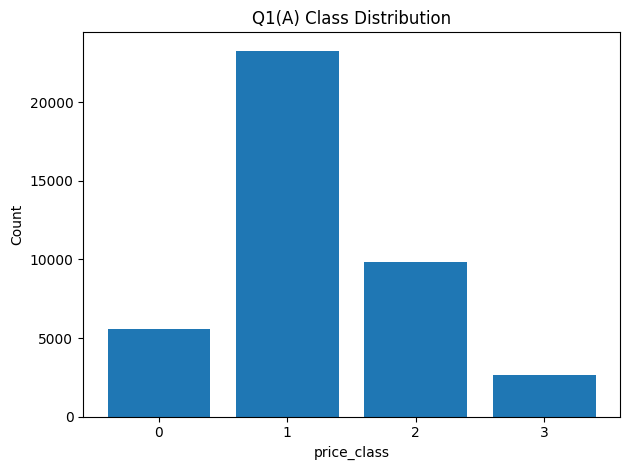

/tmp/ipython-input-2292477774.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


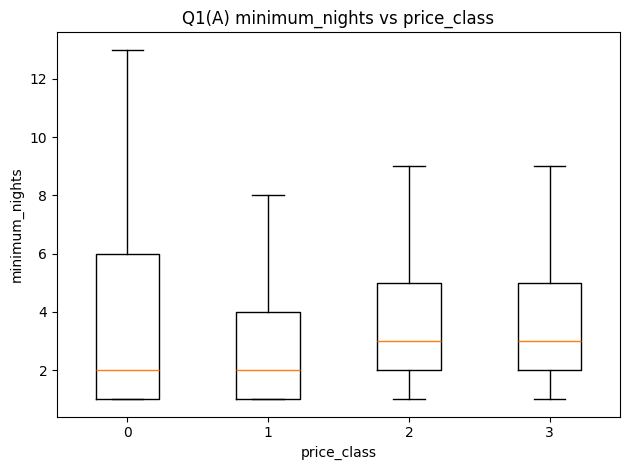

/tmp/ipython-input-2292477774.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


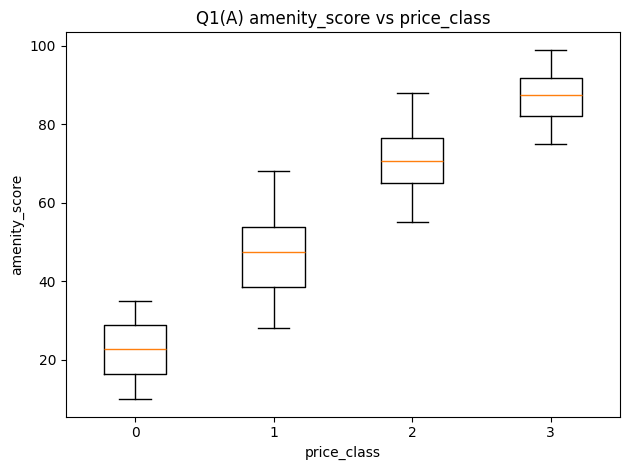

/tmp/ipython-input-2292477774.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


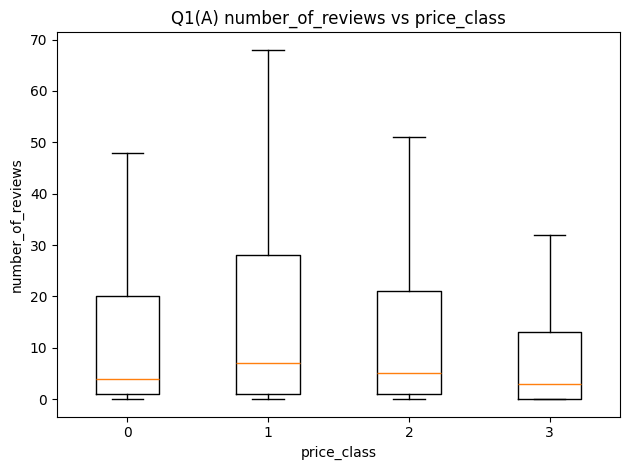

/tmp/ipython-input-2292477774.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


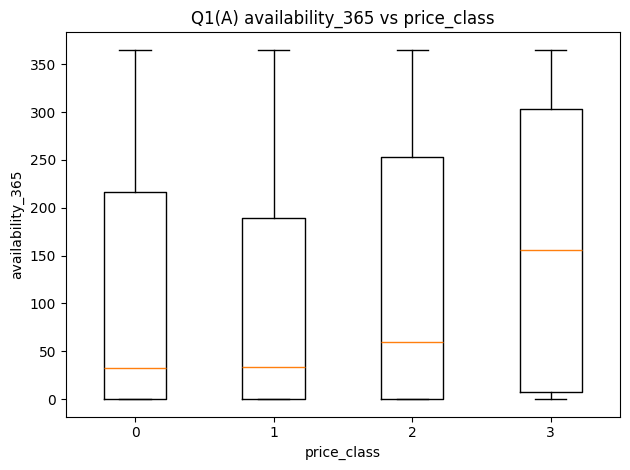

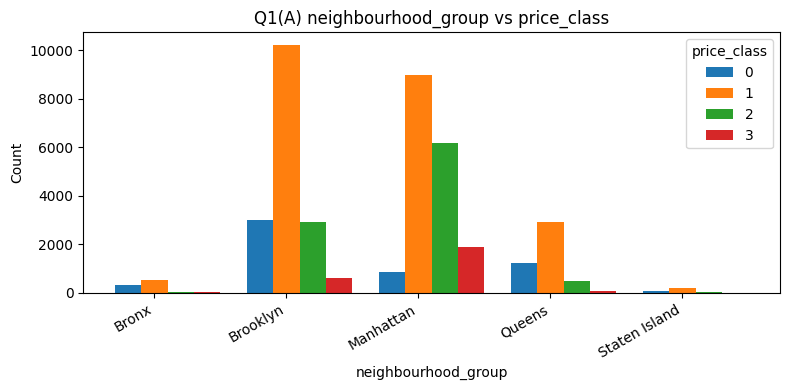

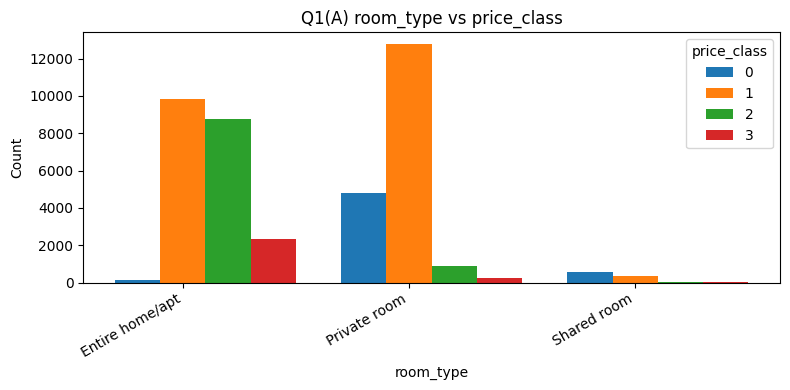

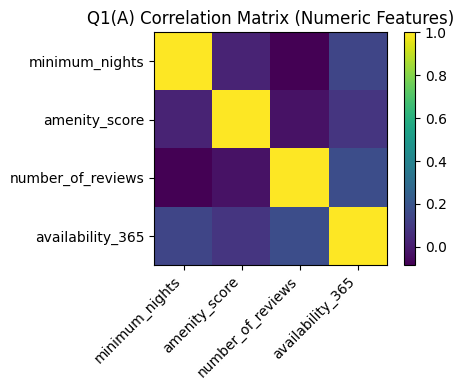


Preprocessed shapes: (33080, 12) (8268, 12) K= 4


In [1]:
# =========================================
# AI600 Assignment 1 (Spring 2026)
# Colab Notebook with Labeled Sections
# =========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"
TARGET = "price_class"

cat_cols = ["neighbourhood_group", "room_type"]
num_cols = ["minimum_nights", "amenity_score", "number_of_reviews", "availability_365"]

# =========================================
# Question 1 (Part A): Data Preprocessing + EDA
# =========================================

df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print("=== Q1(A) Dataset Structure ===")
print("Train shape:", df.shape)
print("Test shape: ", df_test.shape)
print("\nDtypes:\n", df.dtypes)

print("\n=== Q1(A) Missing Values ===")
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
mv_table = pd.DataFrame({"Missing Count": missing, "Missing %": missing_pct})
print(mv_table)

# ---- Class distribution
print("\n=== Q1(A) Class Distribution ===")
class_counts = df[TARGET].value_counts().sort_index()
plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel("price_class")
plt.ylabel("Count")
plt.title("Q1(A) Class Distribution")
plt.tight_layout()
plt.savefig("figures/fig_A1_class_dist.png", dpi=200)
plt.show()

# ---- Numeric vs Target boxplots
for col in num_cols:
    plt.figure()
    data = [df.loc[df[TARGET] == k, col].dropna() for k in sorted(df[TARGET].unique())]
    plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)
    plt.xlabel("price_class")
    plt.ylabel(col)
    plt.title(f"Q1(A) {col} vs price_class")
    plt.tight_layout()
    plt.savefig(f"figures/fig_A2_boxplot_{col}.png", dpi=200)
    plt.show()

# ---- Categorical vs Target bar charts
for col in cat_cols:
    ct = pd.crosstab(df[col], df[TARGET])
    x = np.arange(len(ct.index))
    width = 0.2
    plt.figure(figsize=(8,4))
    for i, cls in enumerate(sorted(df[TARGET].unique())):
        plt.bar(x + i*width, ct[cls], width)
    plt.xticks(x + width, ct.index, rotation=30, ha="right")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Q1(A) {col} vs price_class")
    plt.legend([str(c) for c in sorted(df[TARGET].unique())], title="price_class")
    plt.tight_layout()
    outname = "figures/fig_A3_cat_roomtype.png" if col == "room_type" else "figures/fig_A4_cat_borough.png"
    plt.savefig(outname, dpi=200)
    plt.show()

# ---- Correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(5,4))
plt.imshow(corr.values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Q1(A) Correlation Matrix (Numeric Features)")
plt.colorbar()
plt.tight_layout()
plt.savefig("figures/fig_A5_corr_matrix.png", dpi=200)
plt.show()

# =========================================
# Helper: Stratified Split + Preprocessing (used across parts)
# =========================================

def stratified_split(df, target, val_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    y = df[target].to_numpy().astype(int)
    classes = np.unique(y)

    train_idx, val_idx = [], []
    for c in classes:
        idxs = np.where(y == c)[0].copy()
        rng.shuffle(idxs)
        n_val = int(len(idxs) * val_frac)
        val_idx.extend(idxs[:n_val].tolist())
        train_idx.extend(idxs[n_val:].tolist())

    return df.iloc[train_idx].reset_index(drop=True), df.iloc[val_idx].reset_index(drop=True)

def fit_preprocess(df_train):
    # median for numeric, mode for categorical
    num_med = {c: float(df_train[c].median()) for c in num_cols}
    cat_mode = {c: df_train[c].mode(dropna=True)[0] for c in cat_cols}

    dft = df_train.copy()
    for c in num_cols:
        dft[c] = dft[c].fillna(num_med[c])
    for c in cat_cols:
        dft[c] = dft[c].fillna(cat_mode[c])

    # one-hot categorical
    X_cat = pd.get_dummies(dft[cat_cols], drop_first=False)

    # standardize numeric
    mu = dft[num_cols].mean()
    sig = dft[num_cols].std(ddof=0).replace(0, 1.0)
    X_num = (dft[num_cols] - mu) / sig

    X = pd.concat([X_num, X_cat], axis=1)
    return {"num_med": num_med, "cat_mode": cat_mode, "mu": mu, "sig": sig, "cols": X.columns.tolist()}

def transform(df_any, p):
    dft = df_any.copy()
    for c in num_cols:
        dft[c] = dft[c].fillna(p["num_med"][c])
    for c in cat_cols:
        dft[c] = dft[c].fillna(p["cat_mode"][c])

    X_cat = pd.get_dummies(dft[cat_cols], drop_first=False)
    X_num = (dft[num_cols] - p["mu"]) / p["sig"]

    X = pd.concat([X_num, X_cat], axis=1).reindex(columns=p["cols"], fill_value=0.0)
    return X.to_numpy(dtype=np.float32)

def one_hot(y, K):
    Y = np.zeros((y.shape[0], K), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

df_tr, df_va = stratified_split(df, TARGET, val_frac=0.2, seed=42)
pp = fit_preprocess(df_tr)

Xtr = transform(df_tr, pp)
Xva = transform(df_va, pp)

ytr = df_tr[TARGET].to_numpy().astype(np.int64)
yva = df_va[TARGET].to_numpy().astype(np.int64)

K = int(df[TARGET].max() + 1)
Ytr = one_hot(ytr, K)
Yva = one_hot(yva, K)

feature_cols = pp["cols"]
print("\nPreprocessed shapes:", Xtr.shape, Xva.shape, "K=", K)



=== Q1(Ba) Training: Sigmoid ===
[Q1(Ba) sigmoid] iter 50/200 train=0.5632 val=0.5633
[Q1(Ba) sigmoid] iter 100/200 train=0.7058 val=0.7074
[Q1(Ba) sigmoid] iter 150/200 train=0.7641 val=0.7689
[Q1(Ba) sigmoid] iter 200/200 train=0.8005 val=0.8043

=== Q1(Ba) Training: ReLU ===
[Q1(Ba) relu] iter 50/200 train=0.7928 val=0.7952
[Q1(Ba) relu] iter 100/200 train=0.8209 val=0.8283
[Q1(Ba) relu] iter 150/200 train=0.8268 val=0.8342
[Q1(Ba) relu] iter 200/200 train=0.8294 val=0.8373

FINAL (Q1(Ba))
Sigmoid: train= 0.80054414 val= 0.80430573
ReLU:    train= 0.82941353 val= 0.8373246


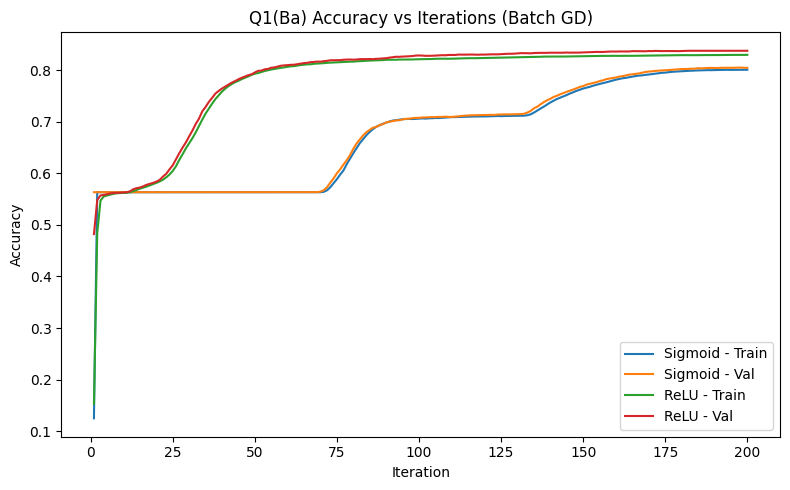

In [2]:
# =========================================
# Question 1 (Part B(a)): 2 Hidden Layer MLP from Scratch (NumPy)
# =========================================

def sigmoid(z): return 1/(1+np.exp(-z))
def relu(z): return np.maximum(0,z)

def softmax(logits):
    z = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def accuracy(probs, y):
    return float((np.argmax(probs, axis=1) == y).mean())

def init_params(d_in, h1, h2, d_out, act, seed=1):
    rg = np.random.default_rng(seed)
    W1 = rg.normal(0,1,(d_in,h1)).astype(np.float32)
    W2 = rg.normal(0,1,(h1,h2)).astype(np.float32)
    W3 = rg.normal(0,1,(h2,d_out)).astype(np.float32)
    b1 = np.zeros((1,h1),dtype=np.float32)
    b2 = np.zeros((1,h2),dtype=np.float32)
    b3 = np.zeros((1,d_out),dtype=np.float32)

    # He init for ReLU; Xavier for Sigmoid
    if act=="relu":
        W1 *= np.sqrt(2/d_in).astype(np.float32)
        W2 *= np.sqrt(2/h1).astype(np.float32)
        W3 *= np.sqrt(2/h2).astype(np.float32)
    else:
        W1 *= np.sqrt(1/d_in).astype(np.float32)
        W2 *= np.sqrt(1/h1).astype(np.float32)
        W3 *= np.sqrt(1/h2).astype(np.float32)

    return {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}

def forward(X, p, act):
    z1 = X@p["W1"] + p["b1"]
    a1 = sigmoid(z1) if act=="sigmoid" else relu(z1)
    z2 = a1@p["W2"] + p["b2"]
    a2 = sigmoid(z2) if act=="sigmoid" else relu(z2)
    logits = a2@p["W3"] + p["b3"]
    probs = softmax(logits)
    cache = (X, z1, a1, z2, a2, probs)
    return probs, cache

def backward(p, cache, Y, act):
    X, z1, a1, z2, a2, probs = cache
    n = X.shape[0]

    dlogits = (probs - Y) / n

    dW3 = a2.T @ dlogits
    db3 = dlogits.sum(axis=0, keepdims=True)

    da2 = dlogits @ p["W3"].T
    if act=="sigmoid":
        dz2 = da2 * (a2*(1-a2))
    else:
        dz2 = da2 * (z2>0).astype(np.float32)

    dW2 = a1.T @ dz2
    db2 = dz2.sum(axis=0, keepdims=True)

    da1 = dz2 @ p["W2"].T
    if act=="sigmoid":
        dz1 = da1 * (a1*(1-a1))
    else:
        dz1 = da1 * (z1>0).astype(np.float32)

    dW1 = X.T @ dz1
    db1 = dz1.sum(axis=0, keepdims=True)

    return {"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2,"dW3":dW3,"db3":db3}

def step(p, g, lr):
    p["W1"] -= lr*g["dW1"]; p["b1"] -= lr*g["db1"]
    p["W2"] -= lr*g["dW2"]; p["b2"] -= lr*g["db2"]
    p["W3"] -= lr*g["dW3"]; p["b3"] -= lr*g["db3"]

def train_batch_gd(act, iters=200, lr=0.2, h1=32, h2=16, seed=1):
    p = init_params(Xtr.shape[1], h1, h2, K, act, seed=seed)
    tr_acc = np.zeros(iters, dtype=np.float32)
    va_acc = np.zeros(iters, dtype=np.float32)

    for t in range(iters):
        probs, cache = forward(Xtr, p, act)
        g = backward(p, cache, Ytr, act)
        step(p, g, lr)

        tr_acc[t] = accuracy(probs, ytr)
        va_acc[t] = accuracy(forward(Xva, p, act)[0], yva)

        if (t+1) % 50 == 0:
            print(f"[Q1(Ba) {act}] iter {t+1}/{iters} train={tr_acc[t]:.4f} val={va_acc[t]:.4f}")

    return p, tr_acc, va_acc

print("\n=== Q1(Ba) Training: Sigmoid ===")
params_sig, sig_tr, sig_va = train_batch_gd("sigmoid", iters=200, lr=0.8, h1=32, h2=16, seed=1)

print("\n=== Q1(Ba) Training: ReLU ===")
params_relu, relu_tr, relu_va = train_batch_gd("relu", iters=200, lr=0.2, h1=32, h2=16, seed=1)

print("\nFINAL (Q1(Ba))")
print("Sigmoid: train=", sig_tr[-1], "val=", sig_va[-1])
print("ReLU:    train=", relu_tr[-1], "val=", relu_va[-1])

# ---- Save accuracy vs iteration plot (single plot)
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,201), sig_tr, label="Sigmoid - Train")
plt.plot(np.arange(1,201), sig_va, label="Sigmoid - Val")
plt.plot(np.arange(1,201), relu_tr, label="ReLU - Train")
plt.plot(np.arange(1,201), relu_va, label="ReLU - Val")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Q1(Ba) Accuracy vs Iterations (Batch GD)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B1_acc_vs_iter.png", dpi=200)
plt.show()


=== Q1(Bb) Gradient magnitudes: Sigmoid ===

=== Q1(Bb) Gradient magnitudes: ReLU ===


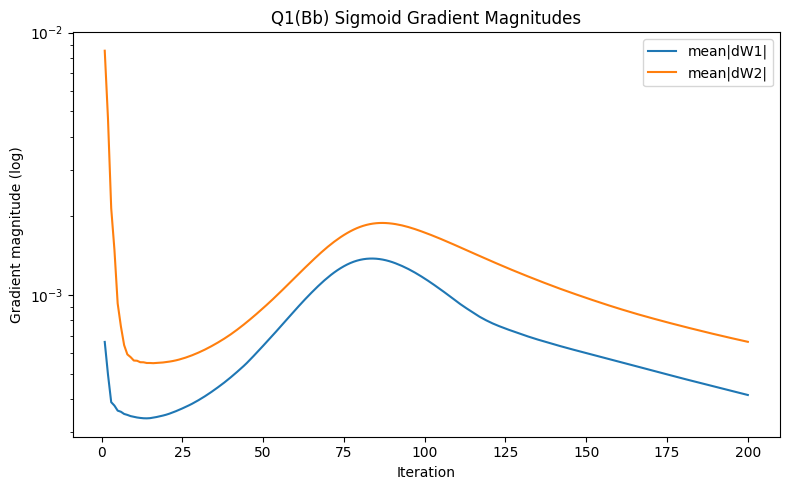

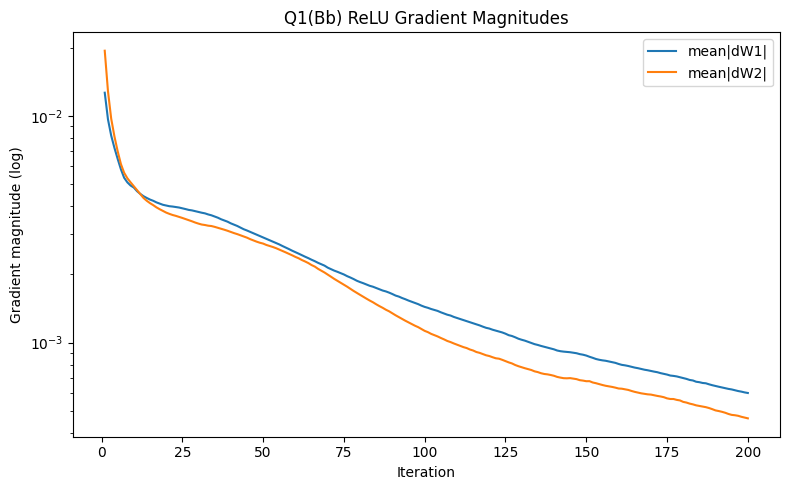

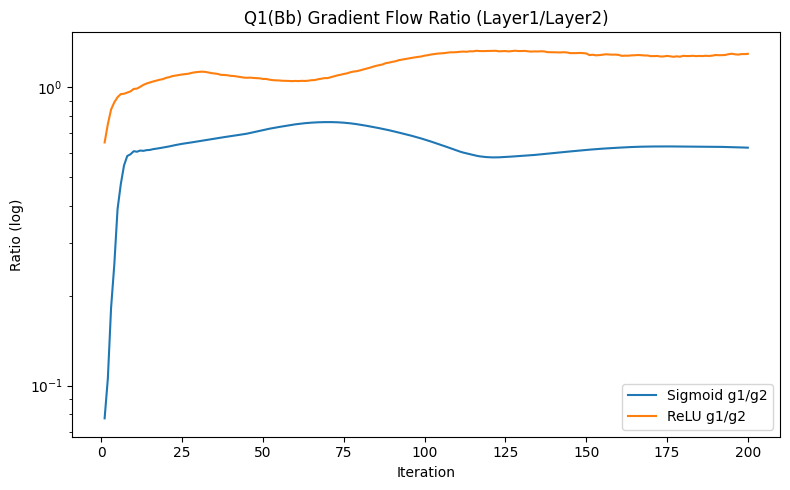

In [3]:
# =========================================
# Question 1 (Part B(b)): Gradient Magnitude Comparison (W1 vs W2)
# =========================================

def train_with_grad_magnitude(act, iters=200, lr=0.2, h1=32, h2=16, seed=1):
    p = init_params(Xtr.shape[1], h1, h2, K, act, seed=seed)
    gW1 = np.zeros(iters, dtype=np.float64)
    gW2 = np.zeros(iters, dtype=np.float64)

    for t in range(iters):
        probs, cache = forward(Xtr, p, act)
        g = backward(p, cache, Ytr, act)

        gW1[t] = np.mean(np.abs(g["dW1"]))
        gW2[t] = np.mean(np.abs(g["dW2"]))

        step(p, g, lr)

    return p, gW1, gW2

print("\n=== Q1(Bb) Gradient magnitudes: Sigmoid ===")
_, sig_g1, sig_g2 = train_with_grad_magnitude("sigmoid", iters=200, lr=0.8, h1=32, h2=16, seed=1)

print("\n=== Q1(Bb) Gradient magnitudes: ReLU ===")
_, relu_g1, relu_g2 = train_with_grad_magnitude("relu", iters=200, lr=0.2, h1=32, h2=16, seed=1)

iters = np.arange(1, 201)

plt.figure(figsize=(8,5))
plt.plot(iters, sig_g1, label="mean|dW1|")
plt.plot(iters, sig_g2, label="mean|dW2|")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Gradient magnitude (log)")
plt.title("Q1(Bb) Sigmoid Gradient Magnitudes")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B2_gradmag_sigmoid.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(iters, relu_g1, label="mean|dW1|")
plt.plot(iters, relu_g2, label="mean|dW2|")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Gradient magnitude (log)")
plt.title("Q1(Bb) ReLU Gradient Magnitudes")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B3_gradmag_relu.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(iters, sig_g1/(sig_g2+1e-12), label="Sigmoid g1/g2")
plt.plot(iters, relu_g1/(relu_g2+1e-12), label="ReLU g1/g2")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Ratio (log)")
plt.title("Q1(Bb) Gradient Flow Ratio (Layer1/Layer2)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B4_grad_ratio.png", dpi=200)
plt.show()



=== Q1(Cb) Top 15 one-hot features ===
amenity_score                        0.000132
room_type_Private room               0.000062
room_type_Entire home/apt            0.000056
neighbourhood_group_Staten Island    0.000042
neighbourhood_group_Manhattan        0.000033
neighbourhood_group_Brooklyn         0.000028
neighbourhood_group_Queens           0.000023
room_type_Shared room                0.000022
neighbourhood_group_Bronx            0.000015
minimum_nights                       0.000015
number_of_reviews                    0.000011
availability_365                     0.000011
dtype: float32

=== Q1(Cb) Grouped ranking (original features) ===
neighbourhood_group    0.000140
room_type              0.000139
amenity_score          0.000132
minimum_nights         0.000015
number_of_reviews      0.000011
availability_365       0.000011
dtype: float64


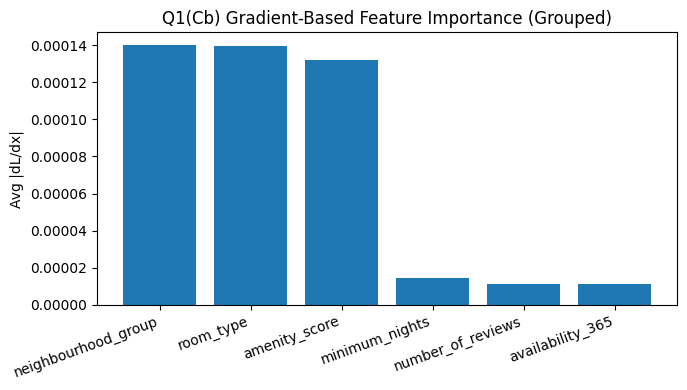

In [4]:
# =========================================
# Question 1 (Part C(b)): Gradient-Based Feature Attribution (Section 2.8)
# =========================================

def feature_attribution_scores(X, Y, params, act="relu"):
    # forward
    probs, cache = forward(X, params, act)
    # backprop deltas (reuse backward but also compute dX)
    X0, z1, a1, z2, a2, probs = cache
    n = X.shape[0]

    dlogits = (probs - Y) / n
    da2 = dlogits @ params["W3"].T

    if act=="sigmoid":
        dz2 = da2 * (a2*(1-a2))
    else:
        dz2 = da2 * (z2>0).astype(np.float32)

    da1 = dz2 @ params["W2"].T
    if act=="sigmoid":
        dz1 = da1 * (a1*(1-a1))
    else:
        dz1 = da1 * (z1>0).astype(np.float32)

    dX = dz1 @ params["W1"].T
    scores = np.mean(np.abs(dX), axis=0)
    return scores

scores = feature_attribution_scores(Xva, Yva, params_relu, act="relu")
feat_scores = pd.Series(scores, index=feature_cols).sort_values(ascending=False)

print("\n=== Q1(Cb) Top 15 one-hot features ===")
print(feat_scores.head(15))

# Grouped ranking (original features)
grouped = {}
for f in num_cols:
    grouped[f] = float(feat_scores.get(f, 0.0))

grouped["neighbourhood_group"] = float(feat_scores[[c for c in feature_cols if c.startswith("neighbourhood_group_")]].sum())
grouped["room_type"] = float(feat_scores[[c for c in feature_cols if c.startswith("room_type_")]].sum())

grouped_rank = pd.Series(grouped).sort_values(ascending=False)

print("\n=== Q1(Cb) Grouped ranking (original features) ===")
print(grouped_rank)

# Optional bar plot for report
plt.figure(figsize=(7,4))
plt.bar(grouped_rank.index, grouped_rank.values)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Avg |dL/dx|")
plt.title("Q1(Cb) Gradient-Based Feature Importance (Grouped)")
plt.tight_layout()
plt.savefig("figures/fig_C1_feature_importance_grouped.png", dpi=200)
plt.show()


Device: cpu

=== Q1(D) Training PyTorch MLP ===
Epoch 01/20 | train_acc=0.7088 val_acc=0.7089
Epoch 02/20 | train_acc=0.8146 val_acc=0.8195
Epoch 03/20 | train_acc=0.8314 val_acc=0.8405
Epoch 04/20 | train_acc=0.8319 val_acc=0.8395
Epoch 05/20 | train_acc=0.8309 val_acc=0.8385
Epoch 06/20 | train_acc=0.8320 val_acc=0.8391
Epoch 07/20 | train_acc=0.8291 val_acc=0.8341
Epoch 08/20 | train_acc=0.8285 val_acc=0.8349
Epoch 09/20 | train_acc=0.8349 val_acc=0.8394
Epoch 10/20 | train_acc=0.8332 val_acc=0.8395
Epoch 11/20 | train_acc=0.8335 val_acc=0.8376
Epoch 12/20 | train_acc=0.8355 val_acc=0.8419
Epoch 13/20 | train_acc=0.8294 val_acc=0.8337
Epoch 14/20 | train_acc=0.8347 val_acc=0.8393
Epoch 15/20 | train_acc=0.8356 val_acc=0.8403
Epoch 16/20 | train_acc=0.8337 val_acc=0.8397
Epoch 17/20 | train_acc=0.8295 val_acc=0.8345
Epoch 18/20 | train_acc=0.8375 val_acc=0.8414
Epoch 19/20 | train_acc=0.8363 val_acc=0.8418
Epoch 20/20 | train_acc=0.8343 val_acc=0.8377


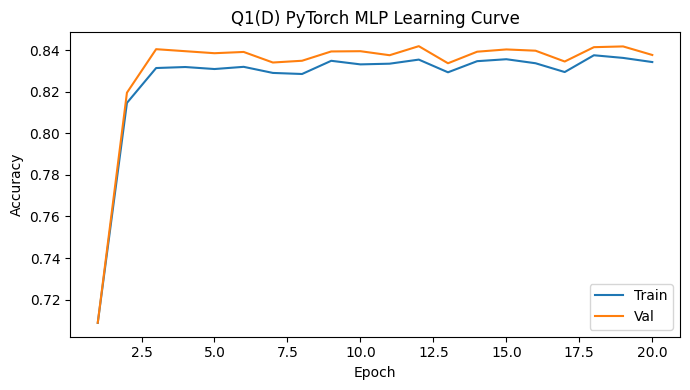


=== Q1(D) Test Accuracy ===
Test accuracy: 0.34329176373852266


In [5]:
# =========================================
# Question 1 (Part D): PyTorch Model + Test Evaluation
# =========================================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("\nDevice:", device)

# Prepare torch tensors
Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
ytr_t = torch.tensor(ytr, dtype=torch.long)
Xva_t = torch.tensor(Xva, dtype=torch.float32)
yva_t = torch.tensor(yva, dtype=torch.long)

# Test preprocessing
Xte = transform(df_test, pp)  # IMPORTANT: use train fitted pp!
yte = None
if TARGET in df_test.columns:
    yte = df_test[TARGET].to_numpy().astype(np.int64)
    yte_t = torch.tensor(yte, dtype=torch.long)

Xte_t = torch.tensor(Xte, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=512, shuffle=False)

class MLP(nn.Module):
    def __init__(self, d_in, h1=32, h2=16, K=4, act="relu"):
        super().__init__()
        self.fc1 = nn.Linear(d_in, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, K)
        self.act = nn.ReLU() if act=="relu" else nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(d_in=Xtr.shape[1], h1=32, h2=16, K=K, act="relu").to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def eval_acc(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct/total

EPOCHS = 20
train_acc_hist = []
val_acc_hist = []

print("\n=== Q1(D) Training PyTorch MLP ===")
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

    tr_acc = eval_acc(train_loader)
    va_acc = eval_acc(val_loader)
    train_acc_hist.append(tr_acc)
    val_acc_hist.append(va_acc)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | train_acc={tr_acc:.4f} val_acc={va_acc:.4f}")

# Plot learning curve
plt.figure(figsize=(7,4))
plt.plot(np.arange(1,EPOCHS+1), train_acc_hist, label="Train")
plt.plot(np.arange(1,EPOCHS+1), val_acc_hist, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Q1(D) PyTorch MLP Learning Curve")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_D1_train_val_curve.png", dpi=200)
plt.show()

# Test accuracy (only if labels exist)
model.eval()
with torch.no_grad():
    logits = model(Xte_t.to(device))
    pred = torch.argmax(logits, dim=1).cpu().numpy()

if yte is not None:
    test_acc = (pred == yte).mean()
    print("\n=== Q1(D) Test Accuracy ===")
    print("Test accuracy:", test_acc)
else:
    print("\nTest labels not present in test.csv, cannot compute test accuracy.")

In [14]:
# =========================================
# FINAL CLEAN VERSION FOR SUBMISSION
# =========================================

# 1. Fit preprocessing on FULL training set
pp = fit_preprocess(df)

X_train_full = transform(df, pp)
y_train_full = df[TARGET].to_numpy().astype(np.int64)

X_test = transform(df_test, pp)
y_test = df_test[TARGET].to_numpy().astype(np.int64)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

Xtr_t = torch.tensor(X_train_full, dtype=torch.float32)
ytr_t = torch.tensor(y_train_full, dtype=torch.long)
Xte_t = torch.tensor(X_test, dtype=torch.float32)
yte_t = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=512, shuffle=False)

class MLP(nn.Module):
    def __init__(self, d_in, h1=32, h2=16, K=4):
        super().__init__()
        self.fc1 = nn.Linear(d_in, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, K)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(d_in=X_train_full.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

# Train on full training data
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        train_acc = evaluate(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc={train_acc:.4f}")

# Final evaluation
train_acc = evaluate(train_loader)
test_acc = evaluate(test_loader)

print("\nFINAL CLEAN RESULTS")
print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)


Epoch 5/20 | Train Acc=0.8281
Epoch 10/20 | Train Acc=0.8341
Epoch 15/20 | Train Acc=0.8368
Epoch 20/20 | Train Acc=0.8339

FINAL CLEAN RESULTS
Train Accuracy: 0.8339460191544935
Test Accuracy : 0.3409620391941894


In [15]:
import os
os.makedirs("figures", exist_ok=True)
print("Figures folder created.")

Figures folder created.


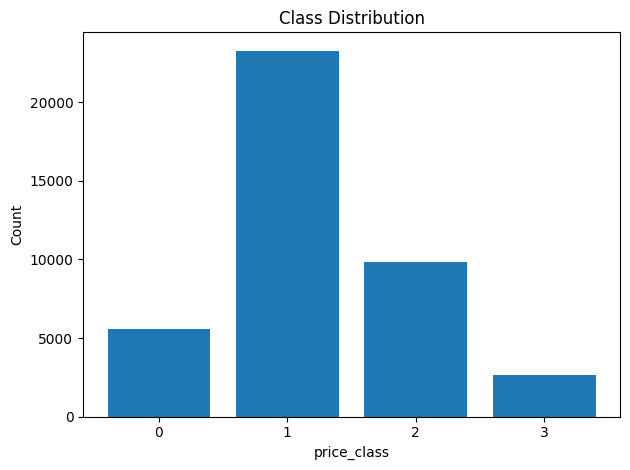

/tmp/ipython-input-3764483056.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


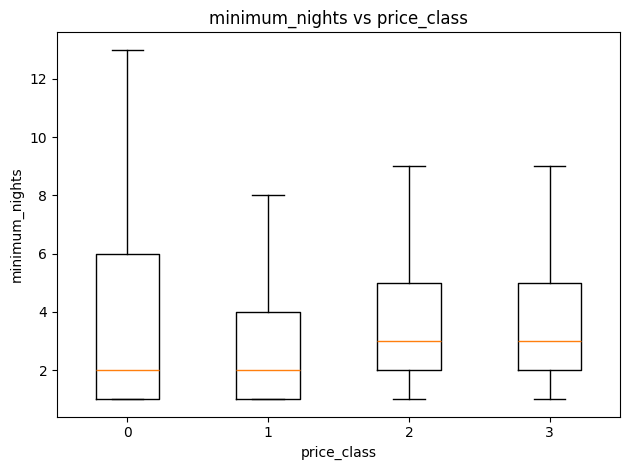

/tmp/ipython-input-3764483056.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


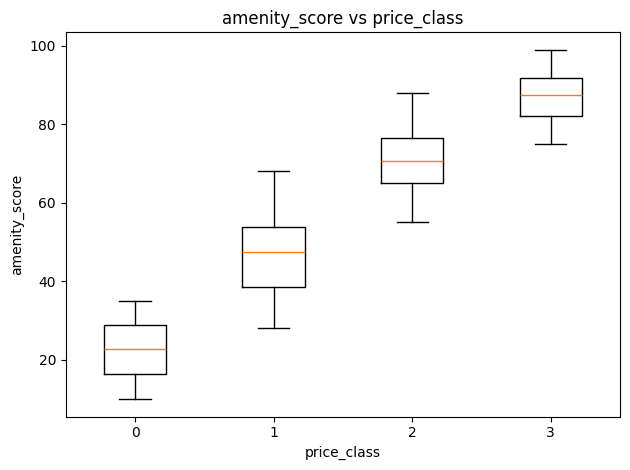

/tmp/ipython-input-3764483056.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


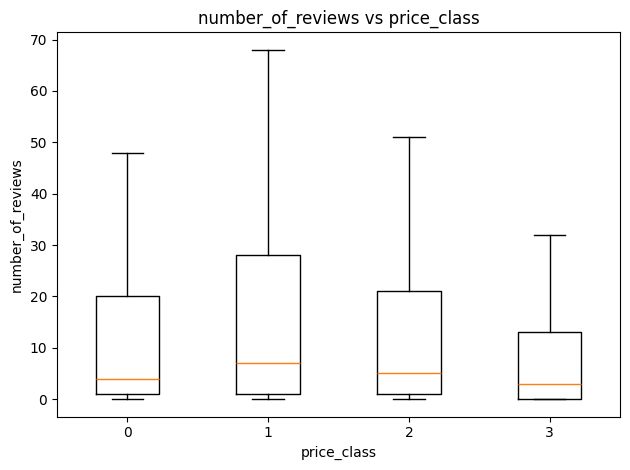

/tmp/ipython-input-3764483056.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)


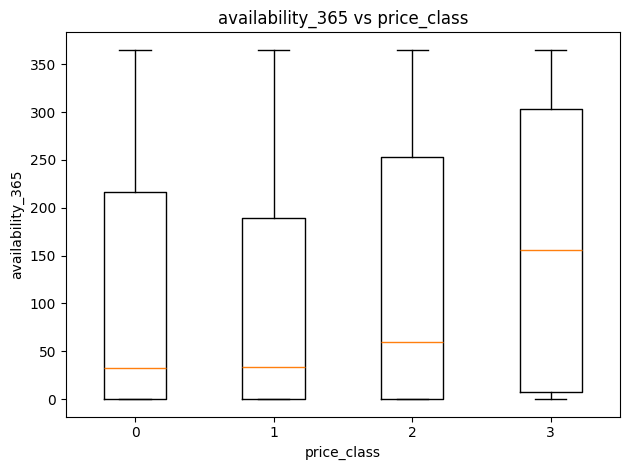

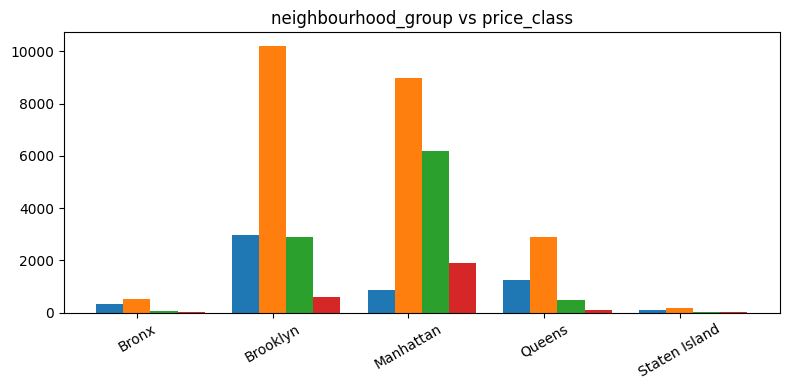

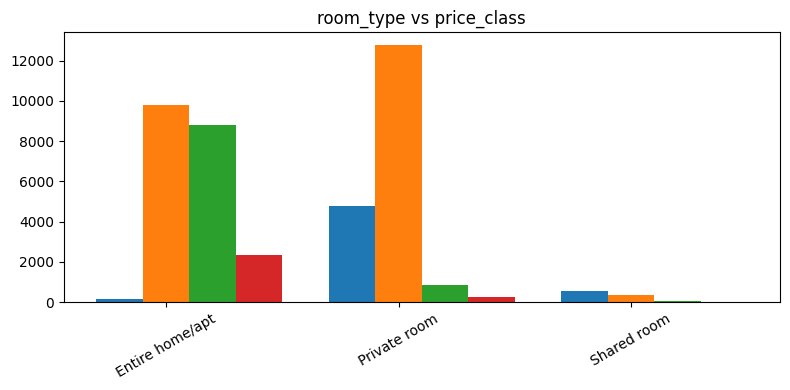

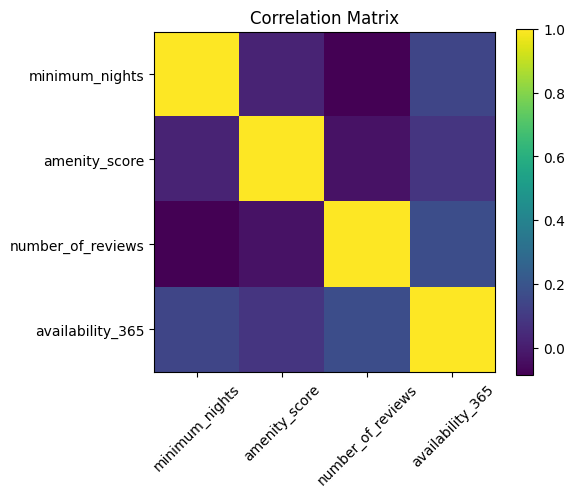

In [16]:
# ===============================
# Q1(A) FIGURES
# ===============================

# Class distribution
class_counts = df[TARGET].value_counts().sort_index()
plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel("price_class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.tight_layout()
plt.savefig("figures/fig_A1_class_distribution.png", dpi=300)
plt.show()

# Numeric boxplots
for col in num_cols:
    plt.figure()
    data = [df.loc[df[TARGET]==k, col].dropna() for k in sorted(df[TARGET].unique())]
    plt.boxplot(data, labels=[str(k) for k in sorted(df[TARGET].unique())], showfliers=False)
    plt.xlabel("price_class")
    plt.ylabel(col)
    plt.title(f"{col} vs price_class")
    plt.tight_layout()
    plt.savefig(f"figures/fig_A2_boxplot_{col}.png", dpi=300)
    plt.show()

# Categorical plots
for col in cat_cols:
    ct = pd.crosstab(df[col], df[TARGET])
    x = range(len(ct.index))
    width = 0.2
    plt.figure(figsize=(8,4))
    for i, cls in enumerate(sorted(df[TARGET].unique())):
        plt.bar([xi+i*width for xi in x], ct[cls], width)
    plt.xticks([xi+width for xi in x], ct.index, rotation=30)
    plt.title(f"{col} vs price_class")
    plt.tight_layout()
    plt.savefig(f"figures/fig_A3_{col}.png", dpi=300)
    plt.show()

# Correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr.values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig("figures/fig_A4_correlation_matrix.png", dpi=300)
plt.show()

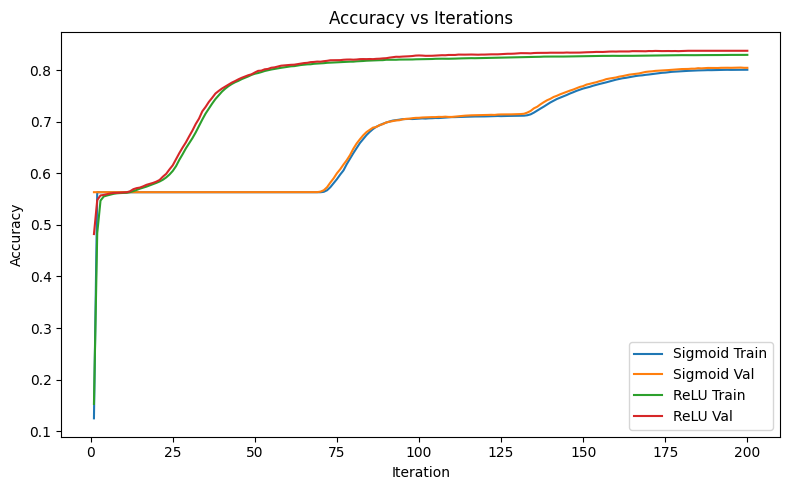

In [17]:
plt.figure(figsize=(8,5))
plt.plot(range(1,201), sig_tr, label="Sigmoid Train")
plt.plot(range(1,201), sig_va, label="Sigmoid Val")
plt.plot(range(1,201), relu_tr, label="ReLU Train")
plt.plot(range(1,201), relu_va, label="ReLU Val")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B1_accuracy_vs_iterations.png", dpi=300)
plt.show()


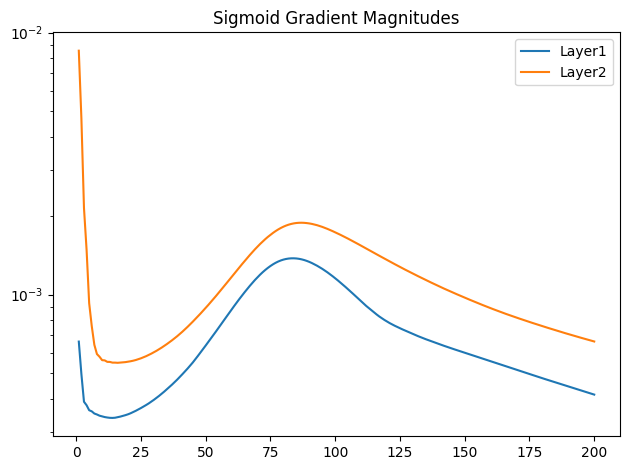

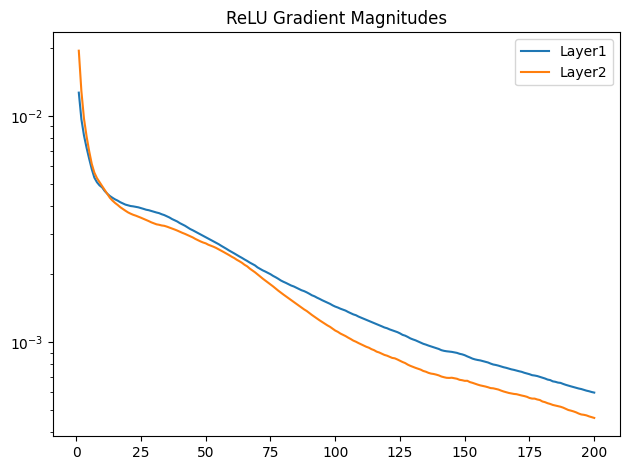

In [18]:
iters = range(1,201)

plt.figure()
plt.plot(iters, sig_g1, label="Layer1")
plt.plot(iters, sig_g2, label="Layer2")
plt.yscale("log")
plt.title("Sigmoid Gradient Magnitudes")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B2_sigmoid_gradients.png", dpi=300)
plt.show()

plt.figure()
plt.plot(iters, relu_g1, label="Layer1")
plt.plot(iters, relu_g2, label="Layer2")
plt.yscale("log")
plt.title("ReLU Gradient Magnitudes")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_B3_relu_gradients.png", dpi=300)
plt.show()


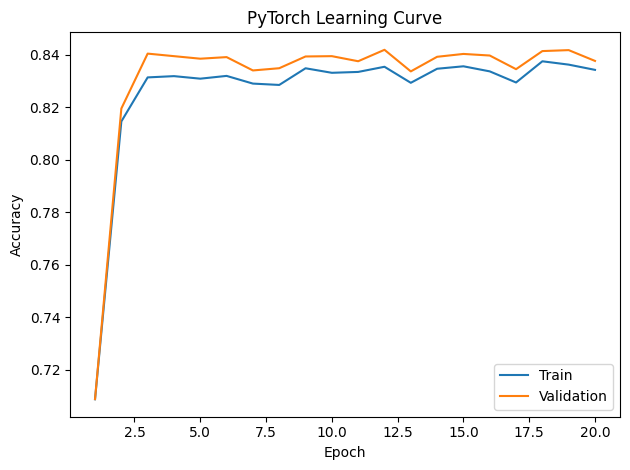

In [19]:
plt.figure()
plt.plot(range(1, len(train_acc_hist)+1), train_acc_hist, label="Train")
plt.plot(range(1, len(val_acc_hist)+1), val_acc_hist, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("PyTorch Learning Curve")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig_D1_pytorch_learning_curve.png", dpi=300)
plt.show()


In [22]:
import shutil
shutil.make_archive("AI600_figures", 'zip', "figures")
print("Zip file created: AI600_figures.zip")


Zip file created: AI600_figures.zip
